In [1]:
# NASH: Neural Adaptive Shrinkage (Amortized Inference Version)
# Author: William Denault

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist

# Simulate data
torch.manual_seed(0)
n, p, d = 100, 2000, 5  # n = samples, p = predictors, d = side info dim
X = torch.randn(n, p)
z = torch.randn(p, d)  # feature-level covariates
true_beta = torch.randn(p) * (torch.rand(p) < 0.2).float()  # sparse


(array([1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 4.000e+00, 4.000e+00, 3.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 4.000e+00, 3.000e+00, 5.000e+00,
        4.000e+00, 3.000e+00, 4.000e+00, 2.000e+00, 5.000e+00, 5.000e+00,
        6.000e+00, 4.000e+00, 4.000e+00, 7.000e+00, 6.000e+00, 9.000e+00,
        3.000e+00, 1.000e+01, 5.000e+00, 7.000e+00, 1.100e+01, 1.200e+01,
        5.000e+00, 1.300e+01, 1.100e+01, 1.601e+03, 1.500e+01, 9.000e+00,
        1.100e+01, 1.000e+01, 9.000e+00, 1.500e+01, 8.000e+00, 1.400e+01,
        1.400e+01, 9.000e+00, 4.000e+00, 5.000e+00, 7.000e+00, 4.000e+00,
        9.000e+00, 6.000e+00, 5.000e+00, 9.000e+00, 1.000e+01, 3.000e+00,
        0.000e+00, 2.000e+00, 6.000e+00, 1.000e+00, 4.000e+00, 3.000e+00,
        4.000e+00, 2.000e+00, 5.000e+0

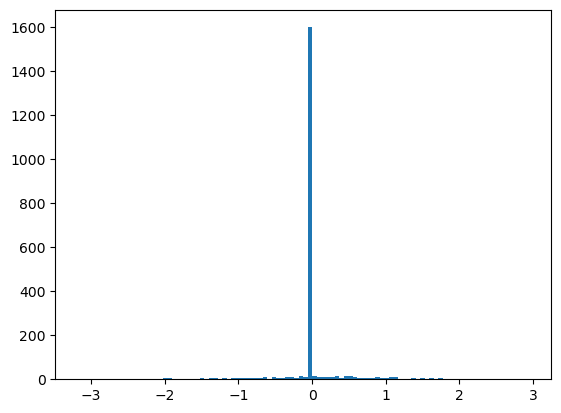

In [5]:
import matplotlib.pyplot as plt
plt.hist(true_beta,bins=100 )

In [6]:
sigma = 0.5
y = X @ true_beta + sigma * torch.randn(n)

# Amortizer: maps (X, y, z) => posterior params and prior lambdas
class Amortizer(nn.Module):
    def __init__(self, p, d):
        super().__init__()
        self.p = p
        self.z_encoder = nn.Sequential(
            nn.Linear(d, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Softplus()
        )
        self.summary_net = nn.Sequential(
            nn.Linear(p + 1, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2 * p)
        )

    def forward(self, X, y, z):
        # Posterior over beta
        x_summary = X.mean(0)
        y_summary = y.mean().unsqueeze(0)
        inp = torch.cat([x_summary, y_summary], dim=0)
        out = self.summary_net(inp)
        mu = out[:self.p]
        log_sigma = out[self.p:]

        # Feature-wise prior shrinkage
        lambda_j = self.z_encoder(z).squeeze(-1)
        return mu, torch.exp(log_sigma), lambda_j

amortizer = Amortizer(p, d)
optimizer = torch.optim.Adam(amortizer.parameters(), lr=1e-3)

# Training loop
for epoch in range(10000):
    optimizer.zero_grad()
    mu, sigma_q, lambda_j = amortizer(X, y, z)
    q_beta = dist.Normal(mu, sigma_q)
    beta_sample = q_beta.rsample()

    # Likelihood
    y_pred = X @ beta_sample
    log_lik = dist.Normal(y_pred, sigma).log_prob(y).sum()

    # Prior: adaptive lambda_j
    p_beta = dist.Normal(torch.zeros(p), (lambda_j * sigma).sqrt())
    kl = dist.kl_divergence(q_beta, p_beta).sum()

    elbo = log_lik - kl
    loss = -elbo
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: ELBO={elbo.item():.2f}, Mean KL={kl.item():.2f}")

# Final output
with torch.no_grad():
    mu, sigma_q, lambda_j = amortizer(X, y, z)
    print("\nPosterior mean of beta:", mu.round(decimals=2))
    print("Posterior std of beta:", sigma_q.round(decimals=2))
    print("Learned prior variances (lambda_j):", lambda_j.round(decimals=2))


Epoch 0: ELBO=-481625.47, Mean KL=800.53
Epoch 500: ELBO=-10333.54, Mean KL=4055.57
Epoch 1000: ELBO=-7214.18, Mean KL=2158.95
Epoch 1500: ELBO=-4297.65, Mean KL=1406.70
Epoch 2000: ELBO=-3111.85, Mean KL=1222.67
Epoch 2500: ELBO=-3042.83, Mean KL=1052.58
Epoch 3000: ELBO=-2135.38, Mean KL=993.69
Epoch 3500: ELBO=-2061.02, Mean KL=911.98
Epoch 4000: ELBO=-2283.01, Mean KL=874.91
Epoch 4500: ELBO=-1795.98, Mean KL=881.93
Epoch 5000: ELBO=-1824.94, Mean KL=834.99
Epoch 5500: ELBO=-1756.34, Mean KL=831.46
Epoch 6000: ELBO=-1616.72, Mean KL=816.32
Epoch 6500: ELBO=-1597.58, Mean KL=822.14
Epoch 7000: ELBO=-1571.26, Mean KL=780.23
Epoch 7500: ELBO=-1627.96, Mean KL=820.41
Epoch 8000: ELBO=-1531.81, Mean KL=782.19
Epoch 8500: ELBO=-1302.06, Mean KL=777.10
Epoch 9000: ELBO=-1419.29, Mean KL=761.86
Epoch 9500: ELBO=-1280.21, Mean KL=784.50

Posterior mean of beta: tensor([ 0.0100, -0.0000, -0.0100,  ..., -0.0100, -0.0000,  0.7800])
Posterior std of beta: tensor([0.0200, 0.0100, 0.0100,  ..., 0

In [11]:
import matplotlib.pyplot as plt

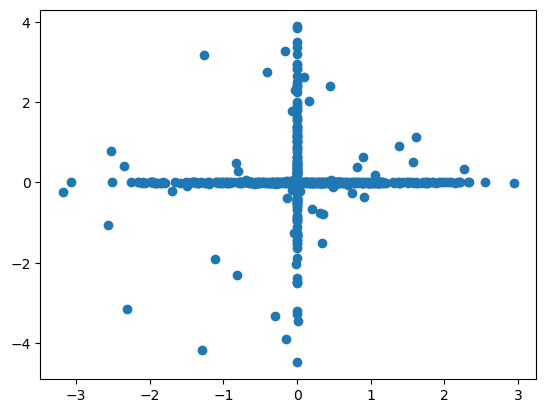

In [12]:
plt.scatter(true_beta ,mu)

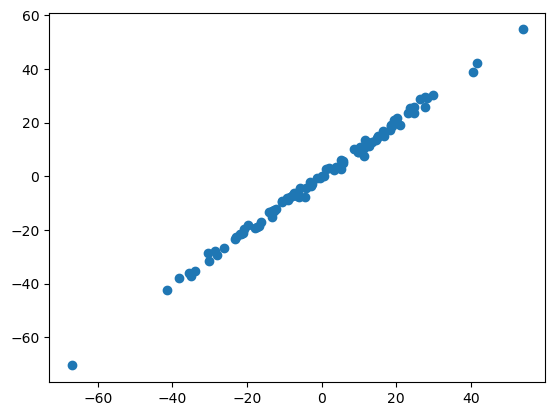

In [13]:
plt.scatter(y, X@mu)